In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string
from keras.callbacks import ModelCheckpoint



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from subtask A 2016 test data 
# TODO instead change the quote char in the read_csv call

# Load the data
fileGlob = glob.glob('./task3Data/*.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','topic','label','raw']
#traindf = traindf.drop(['date'], axis=1)

# Things to try:
Convert the text into vector my using a pre-trained system. 
Convert text into a vector by using a NN to train the embeddings. 

Looks like i need to handle the weird character replacement that's happening

In [3]:
# Need to do some preprocessing on the data to remove stop words, punctuation and probably stem the words too. 
# Need to handle the /u002c and other unicdoe character artifacts that are happening. 
# If removing punctuation then may want to simply remove them 
# but if expanding contractinons will need to convert them first. - a library exists to do this
# Need to check to see what's happening with emojis



In [4]:
def preprocess(tweet, stop_words, target):
    # Handle utf8 unicode problems
    #print(tweet)
    #tweet = emoji.demojize(tweet)
    
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    tweet = contractions.fix(tweet)
    tweet = tweet.lower()
    if target.lower() in tweet:
        tweet = tweet.replace(target,"<TARGETTOKEN>")
        
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('english')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\_'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\m'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\,'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\o'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\l'
  


In [5]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

165
['TARGETTOKEN', 'systems', 'technical', 'university', 'come', 'visit', 'TARGETTOKEN', 'global', 'training', 'providers', 'TARGETTOKEN', 'stu15', 'TARGETTOKEN', 'training', 'starts', '01/sep', 'http', '//t.co/yntxyrlyod']
39
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'TARGETTOKEN', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']


In [6]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 641648318754516992]

print(sample.raw.item())
print(sample.text.item())
print(sample.label.item())
print(sample.topic.item())
sampleLine = preprocess(sample.raw.item(),stop_words, sample.topic.item())
print(sampleLine)
print(sample.topic.item() in sample.raw.item().lower())

I can't stop thinking about the fact that I'm going to be in the presence of Snoop Dogg on Sunday
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
2
snoop dogg
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
True


In [7]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1,'TARGETTOKEN' : 2 }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [8]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 32

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
labelDist = y_val.value_counts()
print(labelDist)
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)


labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64


In [10]:
VOCAB_SIZE = 60000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(labelCount, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 6,080,905
Trainable params: 6,080,905
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Save the best weights to a file so we get the model with the best val acc
weightsFilePath="task3Weights.best.hdf5"
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[checkpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 28s 1ms/step - loss: 0.4456 - acc: 0.8390 - val_loss: 1.2909 - val_acc: 0.5454

Epoch 00001: val_acc improved from -inf to 0.54544, saving model to task3Weights.best.hdf5
Epoch 2/5
22974/22974 [==============================] - 28s 1ms/step - loss: 0.2681 - acc: 0.9054 - val_loss: 1.4444 - val_acc: 0.5303

Epoch 00002: val_acc did not improve from 0.54544
Epoch 3/5
22974/22974 [==============================] - 28s 1ms/step - loss: 0.1749 - acc: 0.9400 - val_loss: 1.6489 - val_acc: 0.5174

Epoch 00003: val_acc did not improve from 0.54544
Epoch 4/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.1190 - acc: 0.9598 - val_loss: 2.0899 - val_acc: 0.4935

Epoch 00004: val_acc did not improve from 0.54544
Epoch 5/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.0925 - acc: 0.9682 - val_loss: 2.2882 - val_acc: 0.5031

Epoch 00005: val_acc did 

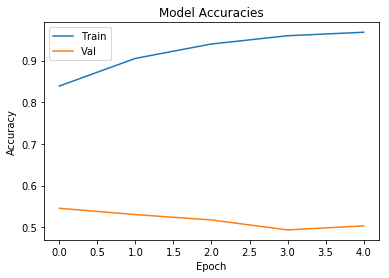

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [20]:
# With stop word removal,string.punctuation word removal, vocab size 60000, padding at 50, get 0.55 val accuracy 
# adding in TARGETTOKEN  increased accuracy by less than 1% 

In [39]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)

y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [40]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [41]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    recalls = []
    precisions = []
    for i in range(noClasses):
        correct = cm[i][i]
        rowTotal = sum(cm[i])
        colTotal = sum(cm[:,i])
        recall = correct / rowTotal
        recalls.append(recall)
        precision = correct / colTotal
        precisions.append(precision)
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses, recalls, precisions

In [42]:
# Rows are the actual, columns are the predicted. strongly negative,  negative, neutral, positve, strongly positive
print(cm)

[[   2   37   21   15    0]
 [   0  231  424  192    3]
 [   0  269 1839 1138    2]
 [   1  112 1013 2096    8]
 [   0    6   40  200    9]]


In [43]:
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

Average fscore: 0.3183766616440792
testAccuracy 0.5454426743275006
Recalls for each class: [0.02666666666666667, 0.27176470588235296, 0.5661945812807881, 0.6489164086687307, 0.03529411764705882]
Precisions for each class [0.6666666666666666, 0.3526717557251908, 0.5510937968234941, 0.5756660258170833, 0.4090909090909091]


## Performance on test data

In [48]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-CE.english.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','topic','label','raw']

testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\ '
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\o'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\_'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\S'
  


In [49]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())

# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

 0    5988
-1    3408
 1    2308
-2     175
 2     131
Name: label, dtype: int64


In [50]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [54]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   1  116   43   15    0]
 [   7 1417 1416  561    7]
 [   1 1544 2912 1520   11]
 [   0  328  753 1200   27]
 [   0   12   16   95    8]]
Average fscore: 0.2915110363198666
testAccuracy 0.4611157368859284
Recalls for each class: [0.005714285714285714, 0.4157863849765258, 0.4863059452237809, 0.5199306759098787, 0.061068702290076333]
Precisions for each class [0.1111111111111111, 0.414691249634182, 0.5665369649805447, 0.3538779121203185, 0.1509433962264151]


Test accuracy was 46.1%, the drop compared to other subtasks is expected as there are more classes for this task, therefore the challenge is harder. Again the average fscore is low because of the poor precision and recall for the extreme cases of strongly negative and strongly positive. The test and trainign data have a large class imbalance which makes this problem harder. Future work could improve the model by addressing the class imbalance. 